<a href="https://colab.research.google.com/github/poluslavik13/innopolis/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%9F%D0%BE%D0%BB%D1%83%D1%81%D0%BC%D0%B0%D0%BA_%D0%92_%D0%98_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Введение. Постановка целей и задач.**


---
**Цель**: проведение исследования данных и построение прогноза розничных продаж алкоголя в США.

**Задачи**:
- провести анализ данных о суммах розничных продаж алкогольной продукции;
- построить прогноз о суммах розничных продаж на 1 год вперед.
---

## **1. Импорт библиотек, ознакомление с данными, предобработка данных.**

### 1.1. Импорт библиотек, функций, датафрейма

In [ ]:
# загружаем pmdarima
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 7.9 MB/s 
     |████████████████████████████████| 9.8 MB 41.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# загружаем fbprophet
!pip install fbprophet

In [ ]:
# импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math

# импортируем модели
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# импортируем метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [ ]:
# импортируем данные
url = 'https://raw.githubusercontent.com/poluslavik13/innopolis/main/Retail_Sales_Beer_Liquor_2018-12-01.csv'
df = pd.read_csv(url)

In [ ]:
# проверяем, что все выгрузилось корректно
df.head()

,DATE,MRTSSM4453USN
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822


### 1.2. Знакомство с данными

In [ ]:
# посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DATE           324 non-null    object
 1   MRTSSM4453USN  324 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [ ]:
# посмотрим на количество записей в датасете
len(df)

324

In [ ]:
# посмотрим на сами данные датасета
df

,DATE,MRTSSM4453USN
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822
...,...,...
319,2018-08-01,4898
320,2018-09-01,4598
321,2018-10-01,4737
322,2018-11-01,5130


### 1.3. Предобработка данных

#### 1.3.1. Обработка заголовков



In [ ]:
# переименуем поля датафрейма
df = df.rename(columns={'DATE': 'date','MRTSSM4453USN': 'rtlsls'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    324 non-null    object
 1   rtlsls  324 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


#### 1.3.2. Обработка пропусков

In [ ]:
# проверим датафрейм на наличие пропусков
print(df.isna().any(axis=None))

False


---
Как видим, пропуски отсутствуют.

---

#### 1.3.3. Обработка типов данных



In [ ]:
# проверим типы данных
df.dtypes

date      object
rtlsls     int64
dtype: object

---
Необходимо для date поменять тип данных для корректного считывания и отображения.

---

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# проверим тип данных после преобразования
df.dtypes

date      datetime64[ns]
rtlsls             int64
dtype: object

In [ ]:
# посмотрим общую информацию о датасете после преобразований
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    324 non-null    datetime64[ns]
 1   rtlsls  324 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


### Заключение по Блоку №1

---
 1. Загружен исследуемый датасет:
  - данные представлены в виде ежемесячной суммы розничных продаж алкоголя с января 1992 года по декабрь 2018 (включительно).
  - сумма ежемесячных продаж конкретного месяца региструется в данных на 1 число данного месяца.
 2. Изменены название полей для удобства дальнейшего использования;
 3. Выполнена проверка на пропуски в данных - пропуски отсутвуют;
 4. Выполнена проверка типов данных и их преобразование:
  -  для поля с датами тип данных изменен с objеct на datetime64[ns].
 5. Для дальнейшего анализа и прогнозирования выбраны все имеющиеся поля датасета.
  -  в качетве метрики для прогноза выбрана сумма розничных продаж.

---

## **2. EDA (exploratory data analysis) или разведочный анализ данных.**

---
**Цель**: познакомиться "поближе" с данными, которыми мы располагаем.

**Задачи**: 
- Сделать столбец с датами индексом;
- Вывести статистику по нужным столбцам;
- Построить графическое отображение столбцов;
- Выявить связи между признаками.

---

In [ ]:
# сделаем столбец с датами - индексом
df.index = df.date

In [ ]:
# посмотрим еще раз размер входной выборки
len(df)

324

In [ ]:
# посмотримн на входную выборку для анализа с добавленным индексом
df.head()

,date,rtlsls
date,,
1992-01-01,1992-01-01,1509
1992-02-01,1992-02-01,1541
1992-03-01,1992-03-01,1597
1992-04-01,1992-04-01,1675
1992-05-01,1992-05-01,1822


In [ ]:
# проведем расчет основных статистических метрик
df.describe()

,rtlsls
count,324.000000
mean,2972.895062
std,1010.218574
min,1501.000000
25%,2109.000000
50%,2791.000000
75%,3627.250000
max,6370.000000


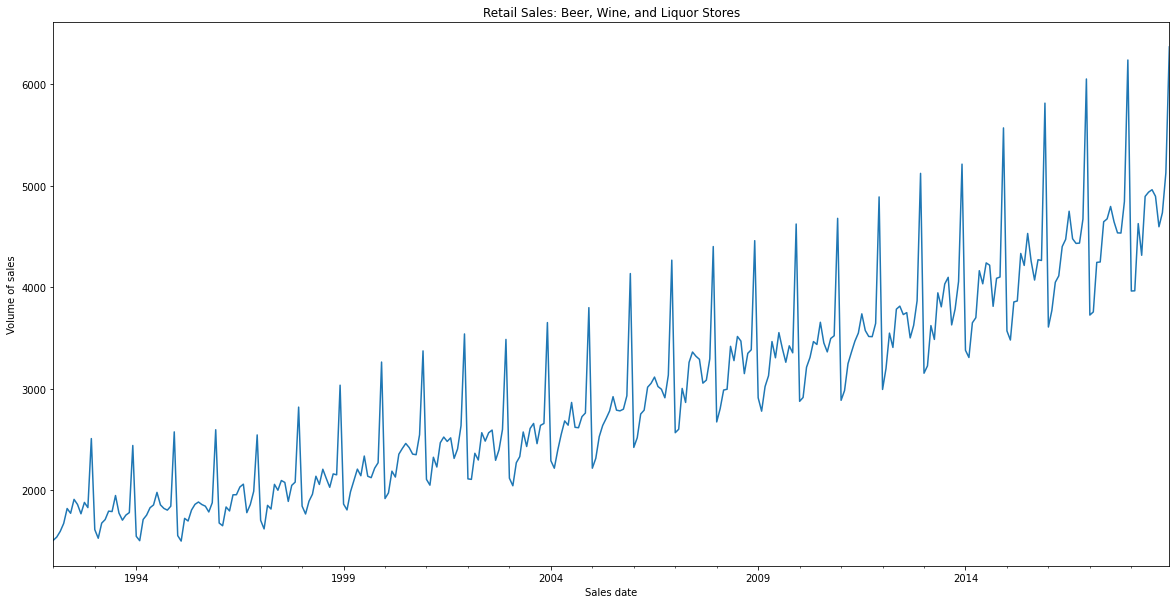

In [ ]:
# построим общий график для метрик
df['rtlsls'].plot(
    figsize=(20, 10), 
    title = 'Retail Sales: Beer, Wine, and Liquor Stores', 
    xlabel = 'Sales date', 
    ylabel = 'Volume of sales')

---
**Промежуточный вывод:**
 1. Наблюдаем общий восходящий тренд: сумма продаж с каждым годом увеличивается;
 2. Наблюдаем сезонные колебания суммы продаж с годовой периодичностью с пиковыми значениями в конце года.

**Строим гипотезу:** увеличение суммы продаж в будущем с сохранением  сезонности.

---

## **3. Построение моделей, анализ результатов.**

### 3.1. Обучающая/контрольная выборки

In [ ]:
# задаем размер тестовой выборки
delta = 12

# выделяем выборки
train = df.iloc[:len(df)-delta]
test = df.iloc[len(df)-delta:]

In [ ]:
# смотрим на обучающую выборку
train.head()

,date,rtlsls
date,,
1992-01-01,1992-01-01,1509
1992-02-01,1992-02-01,1541
1992-03-01,1992-03-01,1597
1992-04-01,1992-04-01,1675
1992-05-01,1992-05-01,1822


In [ ]:
# смотрим на тестовую выборку
test.head()

,date,rtlsls
date,,
2018-01-01,2018-01-01,3965
2018-02-01,2018-02-01,3967
2018-03-01,2018-03-01,4629
2018-04-01,2018-04-01,4317
2018-05-01,2018-05-01,4897


In [ ]:
# дополнительно создаем структуру для будущего сранительного анализа качества моделей, напоняя ее постепенно в ходе построения моделей
mdl_qlt = [];

### 3.2. ETS декомпозиция

In [ ]:
# используем аддитивную модель
r_add = seasonal_decompose(df['rtlsls'], model='additive')

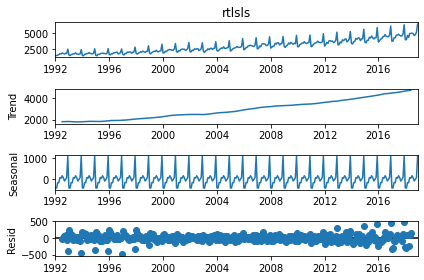

In [ ]:
r_add.plot();

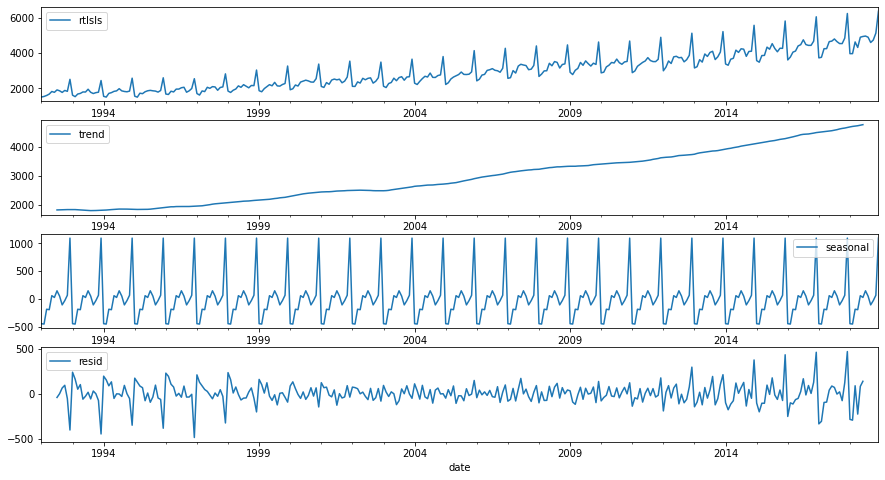

In [ ]:
# seasonal_decompose в увеличенном виде
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
r_add.observed.plot(ax=ax1, legend=True)
r_add.trend.plot(ax=ax2, legend=True)
r_add.seasonal.plot(ax=ax3, legend=True)
r_add.resid.plot(ax=ax4, legend=True)

---
**Промежуточный вывод**:

Наблюдаем годовую сезонность и полодительный тренд.

---

### 3.3. Построение моделей

---
**Задачи**:
- описать модель
- подобрать оптимальные параметры
- создать модель
- обучить модель
- сделать прогноз на период тестовой выборки
- сравнить прогноз с тестовой выборкой (построить график)
- оценить качество прогноза
- сделать прогноз на будущее
- сделать выводы о работе данного метода прогнозирования

---

#### 3.3.1. Метод прогнозирования - SARIMAX

##### Описание модели SARIMAX:

---
Сезонное авторегрессионное интегрированное скользящее среднее, SARIMA или Seasonal ARIMA, является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом.

Он добавляет три новых гиперпараметра для указания авторегрессии (AR), разности (I) и скользящего среднего (MA) для сезонной составляющей ряда, а также дополнительный параметр для периода сезонности.

Сезонная модель ARIMA формируется путем включения дополнительных сезонных терминов в ARIMA. Сезонная часть модели состоит из терминов, которые очень похожи на несезонные компоненты модели, но включают обратные сдвиги сезонного периода.

https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

---

In [ ]:
# Запустим pmdarima.auto_arima чтобы получить набор параметров для нашей модели
auto_arima(df['rtlsls'],seasonal=True, m=12).summary() # включаем сезонность и указываем период сезонности = 1 год

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  324
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1774.379
Date:                              Tue, 22 Mar 2022   AIC                           3570.758
Time:                                      09:32:34   BIC                           3611.896
Sample:                                           0   HQIC                          3587.202
                                              - 324                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0168      0.090    -11.270      0.000      -1.194      -0.840
ar.L2         -0.5759      0.161     -3.571      0.000      -0.892      -0.260
ar.L3          0.4407      0.161      2.744      0.006       0.126       0.755
ar.L4          0.2613      0.090      2.896      0.004       0.084       0.438
ma.L1          0.2127      0.064      3.315      0.001       0.087       0.338
ma.L2         -0.0356      0.064     -0.558      0.577      -0.161       0.090
ma.L3         -0.8716      0.049    -17.710      0.000      -0.968      -0.775
ar.S.L12      -0.9057      0.346     -2.620      0.009      -1.583      -0.228
ar.S.L24      -0.2280      0.080     -2.860      0.004      -0.384      -0.072
ma.S.L12       0.6628      0.345      1.919      0.055      -0.014       1.340
sigma2      5918.8245    521.416     11.351      0.000    4896.868    6940.781
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.67   Prob(JB):                         0.44
Heteroskedasticity (H):               2.02   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---
Промежуточные выводы:

Получилась модель с параметрами SARIMAX(4, 1, 3)x(2, 1, [1], 12)

---

In [ ]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['rtlsls'],order=(4, 1, 3), seasonal_order=(2, 1, 1, 12))

# обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

# получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               rtlsls   No. Observations:                  312
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1704.134
Date:                              Tue, 22 Mar 2022   AIC                           3430.268
Time:                                      09:32:45   BIC                           3470.972
Sample:                                  01-01-1992   HQIC                          3446.559
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9567      0.102     -9.411      0.000      -1.156      -0.757
ar.L2         -0.4635      0.169     -2.748      0.006      -0.794      -0.133
ar.L3          0.5419      0.166      3.261      0.001       0.216       0.868
ar.L4          0.2974      0.099      3.001      0.003       0.103       0.492
ma.L1          0.1851      0.076      2.439      0.015       0.036       0.334
ma.L2         -0.0569      0.075     -0.763      0.446      -0.203       0.089
ma.L3         -0.8670      0.056    -15.584      0.000      -0.976      -0.758
ar.S.L12       0.1140      0.602      0.189      0.850      -1.065       1.293
ar.S.L24      -0.0357      0.171     -0.209      0.835      -0.371       0.300
ma.S.L12      -0.3495      0.604     -0.579      0.563      -1.533       0.834
sigma2      6152.6193    597.072     10.305      0.000    4982.380    7322.858
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.67   Prob(JB):                         0.41
Heteroskedasticity (H):               1.97   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# предсказываем значения, передав модели точку начала и окончания
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename('Predictions SARIMAX(4, 1, 3)x(2, 1, [1], 12)')

In [ ]:
prediction_sarimax

2018-01-01    3905.200647
2018-02-01    4038.040662
2018-03-01    4410.312179
2018-04-01    4411.745963
2018-05-01    4879.902136
2018-06-01    4814.586984
2018-07-01    4987.040898
2018-08-01    4881.662195
2018-09-01    4673.707389
2018-10-01    4736.389560
2018-11-01    5046.701578
2018-12-01    6363.057964
Freq: MS, Name: Predictions SARIMAX(4, 1, 3)x(2, 1, [1], 12), dtype: float64

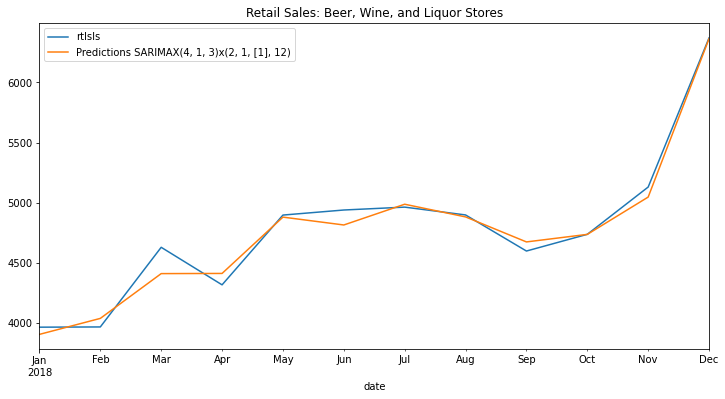

In [ ]:
# сравниваем прогноз и тестовую выборку
ax = test['rtlsls'].plot(legend=True, figsize=(12,6),title='Retail Sales: Beer, Wine, and Liquor Stores')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [ ]:
# оцениваем качество модели методом MSE, RMSE, MAE, MAPE
SARIMAX_mae_error = mean_absolute_error(test['rtlsls'], prediction_sarimax)
SARIMAX_mse_error = mean_squared_error(test['rtlsls'], prediction_sarimax)
SARIMAX_rmse_error = rmse(test['rtlsls'], prediction_sarimax)
SARIMAX_mape_error = np.mean(np.abs(prediction_sarimax - test['rtlsls'])/test['rtlsls'])*100

print(f'SARIMAX(4, 1, 3)x(2, 1, [1], 12) MAE Error: {SARIMAX_mae_error:11.10}')
print(f'SARIMAX(4, 1, 3)x(2, 1, [1], 12) MSE Error: {SARIMAX_mse_error:11.10}')
print(f'SARIMAX(4, 1, 3)x(2, 1, [1], 12) RMSE Error: {SARIMAX_rmse_error:11.10}')
print(f'SARIMAX(4, 1, 3)x(2, 1, [1], 12) MAPE Error: {SARIMAX_mape_error:11.10}')

SARIMAX(4, 1, 3)x(2, 1, [1], 12) MAE Error: 66.06013915
SARIMAX(4, 1, 3)x(2, 1, [1], 12) MSE Error: 7896.543616
SARIMAX(4, 1, 3)x(2, 1, [1], 12) RMSE Error: 88.86249837
SARIMAX(4, 1, 3)x(2, 1, [1], 12) MAPE Error: 1.441353299


In [ ]:
# добавляем данные в структуру оценки качетва моделей
mdl_qlt.append(['SARIMAX(4, 1, 3)x(2, 1, [1], 12)', SARIMAX_mae_error, SARIMAX_mse_error, SARIMAX_rmse_error, SARIMAX_mape_error])

In [ ]:
# проверяем
mdl_qlt

[['SARIMAX(4, 1, 3)x(2, 1, [1], 12)',
  66.06013914882696,
  7896.543616365456,
  88.8624983689152,
  1.4413532991400255]]

In [ ]:
# делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df['rtlsls'],order=(4, 1, 3), seasonal_order=(2, 1, 1, 12))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               rtlsls   No. Observations:                  324
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1774.379
Date:                              Tue, 22 Mar 2022   AIC                           3570.758
Time:                                      09:32:57   BIC                           3611.896
Sample:                                  01-01-1992   HQIC                          3587.202
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0168      0.090    -11.270      0.000      -1.194      -0.840
ar.L2         -0.5759      0.161     -3.571      0.000      -0.892      -0.260
ar.L3          0.4407      0.161      2.744      0.006       0.126       0.755
ar.L4          0.2613      0.090      2.896      0.004       0.084       0.438
ma.L1          0.2127      0.064      3.315      0.001       0.087       0.338
ma.L2         -0.0356      0.064     -0.558      0.577      -0.161       0.090
ma.L3         -0.8716      0.049    -17.710      0.000      -0.968      -0.775
ar.S.L12      -0.9057      0.346     -2.620      0.009      -1.583      -0.228
ar.S.L24      -0.2280      0.080     -2.860      0.004      -0.384      -0.072
ma.S.L12       0.6628      0.345      1.919      0.055      -0.014       1.340
sigma2      5918.8245    521.416     11.351      0.000    4896.868    6940.781
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.67   Prob(JB):                         0.44
Heteroskedasticity (H):               2.02   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

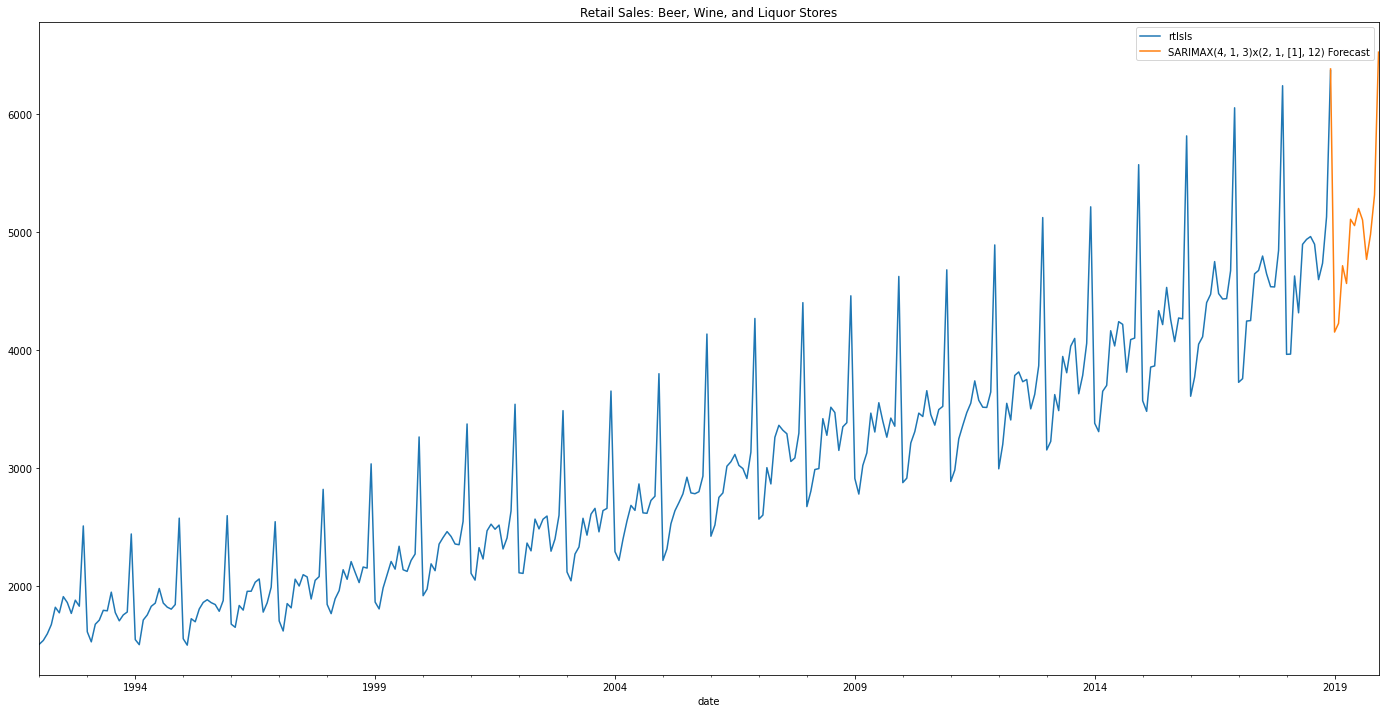

In [ ]:
# задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMAX(4, 1, 3)x(2, 1, [1], 12) Forecast')

# строим график на будущее
ax = df['rtlsls'].plot(legend=True, figsize=(24,12),title='Retail Sales: Beer, Wine, and Liquor Stores') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

##### Выводы работы метода SARIMAX

---
Модель показала себя хорошо:
1.   RMSE=88.86 - это очень хороший показатель.
2.   Процент рассчитанной ошибки MAPE=1.44%, это хороший результат.

>
Согласно графику, на будущее видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается.

---

#### 3.3.2. Метод прогнозирования - PROPHET

##### Описание модели PROPHET:

---
Prophet — это библиотека с открытым исходным кодом от компании Facebook. Она предназначена для прогнозирования временных рядов. По словам разработчиков (команды Core Data Science team) данный инструмент хорошо работает с рядами, которые имеют ярко выраженные сезонные эффекты, а также имеют несколько таких периодов. Prophet устойчив к отсутствию данных и достаточно хорошо справляется с выбросами.

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

---

In [ ]:
# подготовим данные для модели
train_prophet = train[['date','rtlsls']]
test_prophet = test[['date','rtlsls']]

# переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [ ]:
# подготовим данные по всему датасету для модели
df_prophet = df[['date','rtlsls']]
df_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [ ]:
# создаем модель с подобранными параметрами
model_prophet = Prophet(seasonality_mode='multiplicative') # создаем объект модели профет, не устанавливая параметры (модель самостоятельно подбирает параметры)

# обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---
Промежуточные выводы:

Алгоритм проигнорировал, выбирая параметры:

1. `Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.`

    - недельную сезонность (*недельная сезонность может использоваться в случае, если данные собираются по дням, в нашем случае данные представлены по месяцам*)


2. `INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.`

    - дневную сезонность (*дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам*).

Зато он обнаружил годовую сезонность и использовал её при настройке модели.

---

In [ ]:
# говорим профету сделать датафрейм на delta месяцев вперед
future_prophet = model_prophet.make_future_dataframe(periods=delta, freq='MS')
future_prophet.tail(delta) # выводим delta строк с конца

,ds
312,2018-01-01
313,2018-02-01
314,2018-03-01
315,2018-04-01
316,2018-05-01
317,2018-06-01
318,2018-07-01
319,2018-08-01
320,2018-09-01
321,2018-10-01


In [ ]:
# предсказываем значения по модели, доверительный интервал по умолчанию 95%
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1992-01-01,1784.258902,1416.117690,1579.336760,1784.258902,1784.258902,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,0.0,0.0,0.0,1500.365543
1,1992-02-01,1786.020989,1449.081997,1612.248778,1786.020989,1786.020989,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,0.0,0.0,0.0,1529.625391
2,1992-03-01,1787.669394,1593.668955,1758.217641,1787.669394,1787.669394,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,0.0,0.0,0.0,1676.154767
3,1992-04-01,1789.431481,1585.383163,1747.201748,1789.431481,1789.431481,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,0.0,0.0,0.0,1671.215573
4,1992-05-01,1791.136727,1746.434714,1902.176667,1791.136727,1791.136727,0.017738,0.017738,0.017738,0.017738,0.017738,0.017738,0.0,0.0,0.0,1822.907379


In [ ]:
# устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1992-01-01,1992-01-01,1784.258902,1416.117690,1579.336760,1784.258902,1784.258902,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,0.0,0.0,0.0,1500.365543
1992-02-01,1992-02-01,1786.020989,1449.081997,1612.248778,1786.020989,1786.020989,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,0.0,0.0,0.0,1529.625391
1992-03-01,1992-03-01,1787.669394,1593.668955,1758.217641,1787.669394,1787.669394,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,0.0,0.0,0.0,1676.154767
1992-04-01,1992-04-01,1789.431481,1585.383163,1747.201748,1789.431481,1789.431481,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,0.0,0.0,0.0,1671.215573
1992-05-01,1992-05-01,1791.136727,1746.434714,1902.176667,1791.136727,1791.136727,0.017738,0.017738,0.017738,0.017738,0.017738,0.017738,0.0,0.0,0.0,1822.907379


---
Промежуточные выводы:

Основные поля в прогнозе следующие:
- `ds` — дата прогноза
- `yhat` — спрогнозированное значение
- `yhat_lower` — нижняя граница доверительного интервала для прогноза
- `yhat_upper` — верхняя граница доверительного интервала для прогноза
---

In [ ]:
prediction_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(delta) # оставим только нужные

,ds,yhat,yhat_lower,yhat_upper
ds,,,,
2018-01-01,2018-01-01,3962.959092,3879.522092,4040.604758
2018-02-01,2018-02-01,3965.877937,3881.781979,4049.423497
2018-03-01,2018-03-01,4383.665469,4297.353184,4468.351924
2018-04-01,2018-04-01,4416.378499,4335.169318,4497.810480
2018-05-01,2018-05-01,4827.757147,4742.714786,4905.210737
2018-06-01,2018-06-01,4786.736915,4713.790316,4870.929617
2018-07-01,2018-07-01,5019.225979,4942.688394,5102.603039
2018-08-01,2018-08-01,4867.041933,4789.397676,4944.796182
2018-09-01,2018-09-01,4627.190349,4547.799718,4705.449597


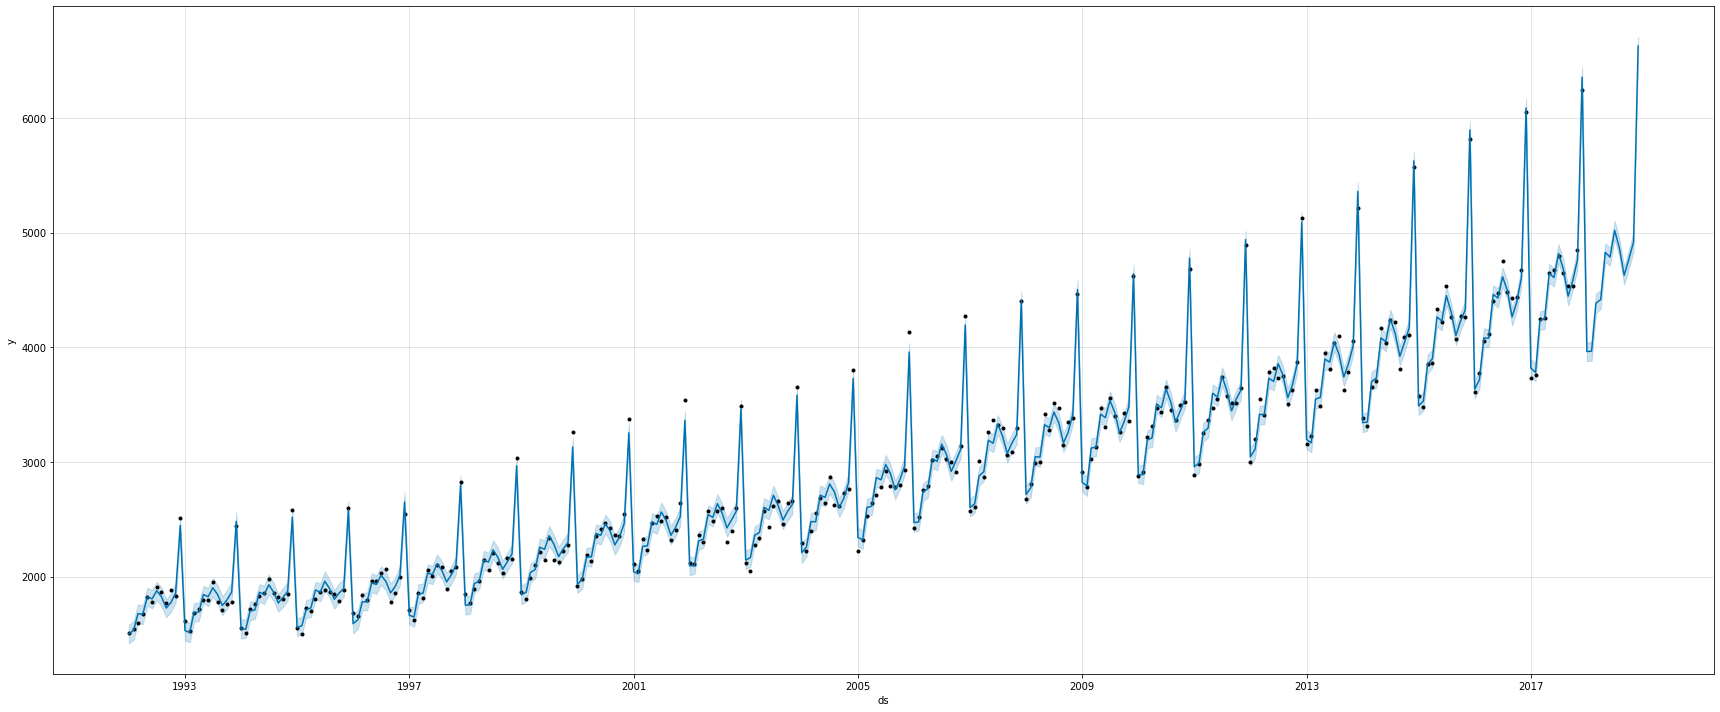

In [ ]:
# сравниваем прогноз и тестовую выборку, где черные точки - выборка
model_prophet.plot(prediction_prophet, figsize=(24,10));

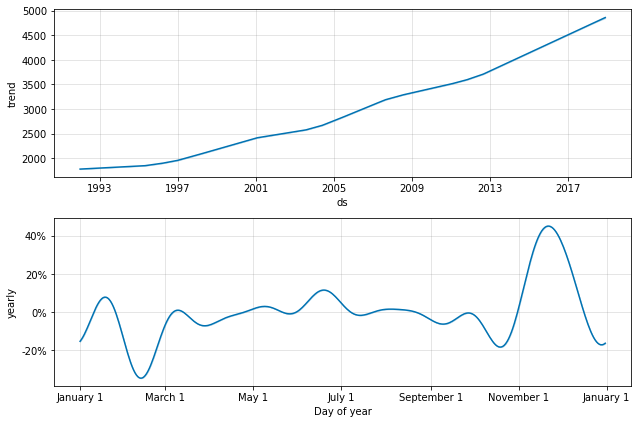

In [ ]:
# разложим ряд на основные компоненты — тренд и сезонность
model_prophet.plot_components(prediction_prophet); # plot_components() — возвращает несколько графиков, среди которых тренд и столько сезонностей, сколько он найдет.

---
Промежуточные выводы:

Видим, что тренд розничных продаж возрастающий, а также есть годовая сезонность.

Видим каким образом изменяются продажи по месяцам.

---

In [ ]:
# оцениваем качество модели методом MSE, RMSE, MAE, MAPE
PROPHET_mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(delta))
PROPHET_mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(delta))
PROPHET_rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(delta))
PROPHET_mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {PROPHET_mae_error:11.10}')
print(f'Prophet MSE Error: {PROPHET_mse_error:11.10}')
print(f'Prophet RMSE Error: {PROPHET_rmse_error:11.10}')
print(f'Prophet MAPE Error: {PROPHET_mape_error:11.10}')

Prophet MAE Error: 98.73289647
Prophet MSE Error: 17973.33688
Prophet RMSE Error: 134.0646743
Prophet MAPE Error: 1.947700413


In [ ]:
# добавляем данные в структуру оценки качетва моделей
mdl_qlt.append(['PROPHET', PROPHET_mae_error, PROPHET_mse_error, PROPHET_rmse_error, PROPHET_mape_error])

In [ ]:
# проверяем
mdl_qlt

[['SARIMAX(4, 1, 3)x(2, 1, [1], 12)',
  66.06013914882696,
  7896.543616365456,
  88.8624983689152,
  1.4413532991400255],
 ['PROPHET',
  98.73289646585067,
  17973.336882075644,
  134.06467425118237,
  1.9477004132111595]]

In [ ]:
# делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_prophet)

# говорим профету сделать дата-фрейм на 1 год вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=12, freq='MS')
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


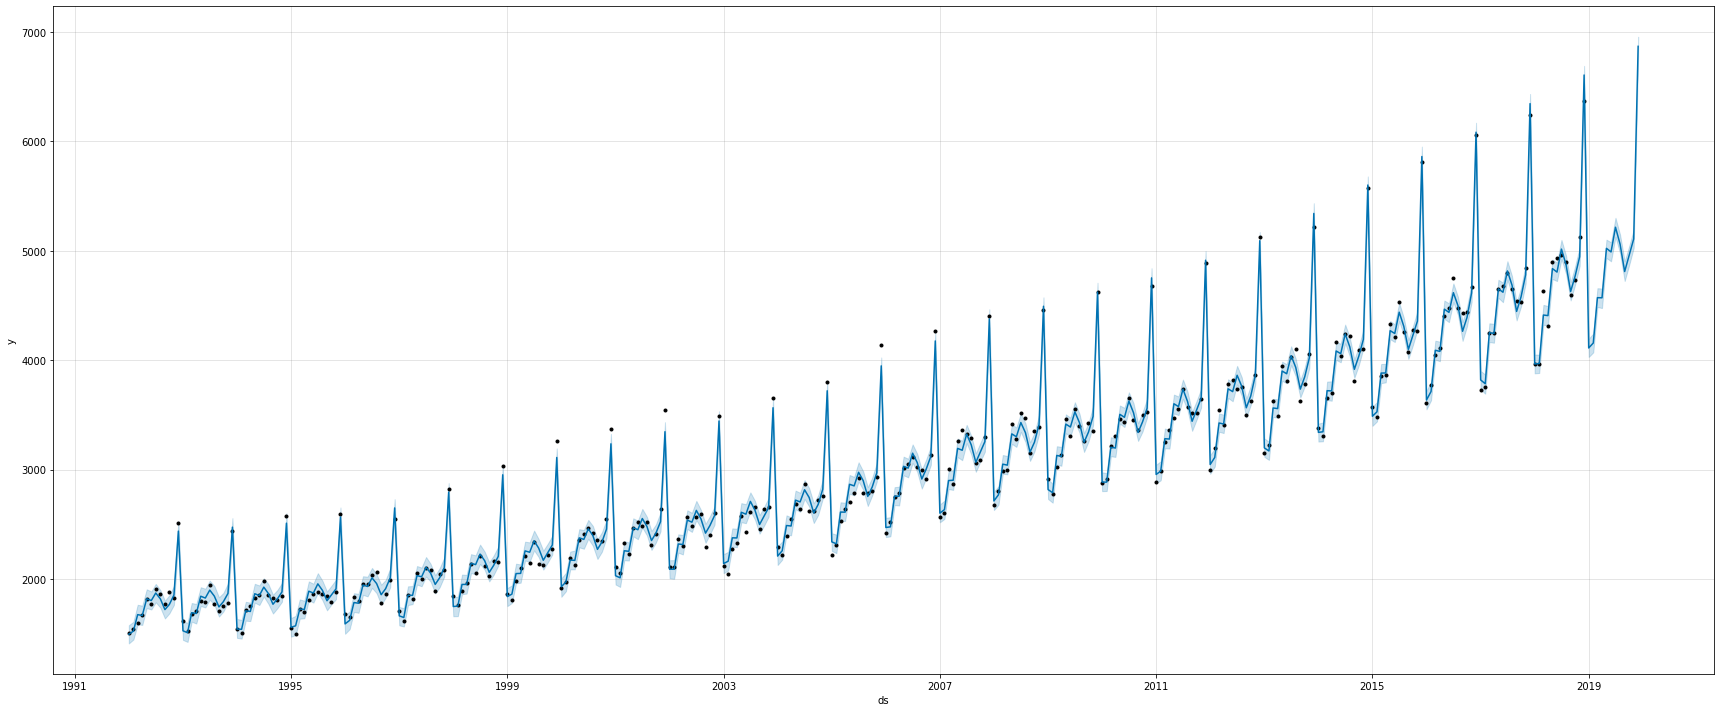

In [ ]:
# сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet, figsize=(24,10));

In [ ]:
# устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [ ]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1992-01-01,1992-01-01,1779.686013,1412.018841,1578.790491,1779.686013,1779.686013,-0.159144,-0.159144,-0.159144,-0.159144,-0.159144,-0.159144,0.0,0.0,0.0,1496.459598
1992-02-01,1992-02-01,1781.689113,1447.889818,1609.589588,1781.689113,1781.689113,-0.144187,-0.144187,-0.144187,-0.144187,-0.144187,-0.144187,0.0,0.0,0.0,1524.792775
1992-03-01,1992-03-01,1783.562982,1587.794448,1765.799406,1783.562982,1783.562982,-0.060513,-0.060513,-0.060513,-0.060513,-0.060513,-0.060513,0.0,0.0,0.0,1675.633708
1992-04-01,1992-04-01,1785.566083,1581.113244,1757.151407,1785.566083,1785.566083,-0.066158,-0.066158,-0.066158,-0.066158,-0.066158,-0.066158,0.0,0.0,0.0,1667.436368
1992-05-01,1992-05-01,1787.504567,1735.977129,1907.026526,1787.504567,1787.504567,0.018569,0.018569,0.018569,0.018569,0.018569,0.018569,0.0,0.0,0.0,1820.696922


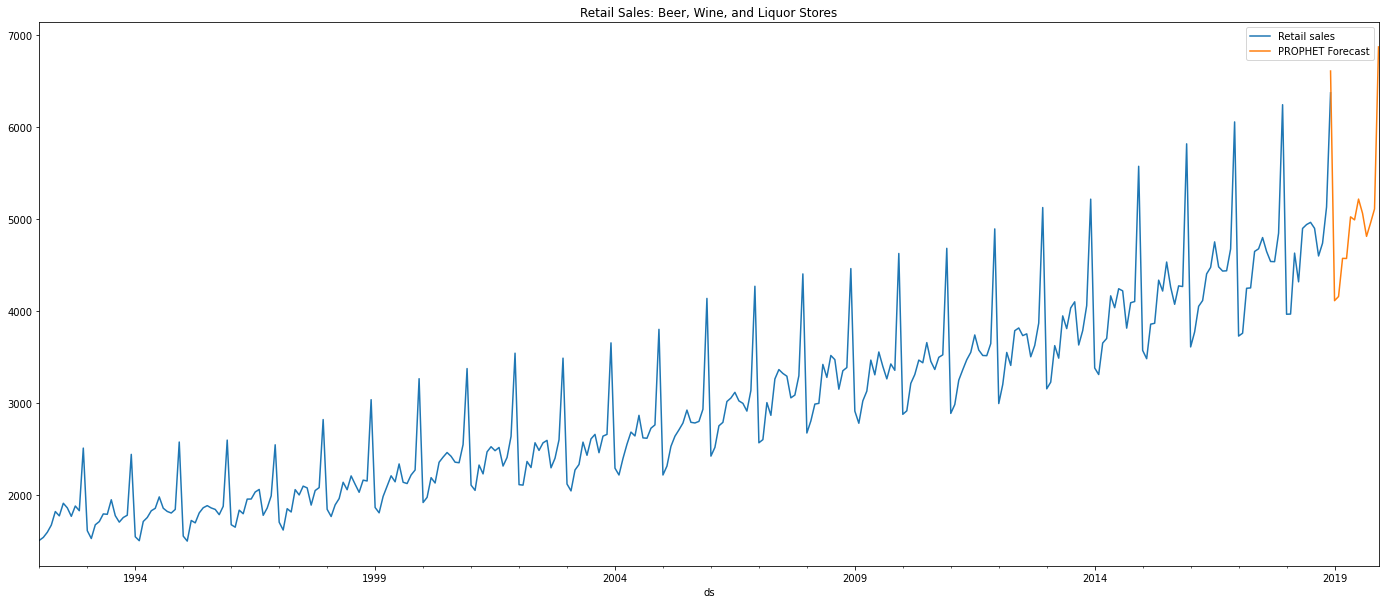

In [ ]:
# строим график на будущее
ax = df_prophet['y'].plot(legend=True, figsize=(24,10),title='Retail Sales: Beer, Wine, and Liquor Stores') 
fut_fcast_prophet['yhat'].tail(13).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Retail sales", "PROPHET Forecast"]);

##### Выводы работы метода PROPHET

---
Модель показала себя хорошо:
1.   RMSE=134.06 - хороший показатель.
2.   Процент рассчитанной ошибки MAPE=1.94% - это хороший результат.

>
Согласно графику, на будущее видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается.

---

#### 3.3.3. Метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)

##### Описание модели Exponential smoothing:

---
Экспоненциальное сглаживание — метод математического преобразования, используемый при прогнозировании временных рядов.

Метод также известен как метод простого экспоненциального сглаживания, или метод Брауна

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html


---

In [ ]:
# создаем 4 модели с подобранными параметрами и обучаем их на обучающей выборке данных
model_exps_1 = ExponentialSmoothing(
    train['rtlsls'], 
    seasonal_periods=12, 
    trend = 'add',
    seasonal = 'add',
    use_boxcox=True,
    freq='MS'
).fit()

model_exps_2 = ExponentialSmoothing(
    train['rtlsls'], 
    seasonal_periods=12, 
    trend = 'add',
    seasonal = 'mul',
    use_boxcox=True,
    freq='MS'
).fit()

model_exps_3 = ExponentialSmoothing(
    train['rtlsls'], 
    seasonal_periods=12, 
    trend = 'mul',
    seasonal = 'add',
    use_boxcox=True,
    freq='MS'
).fit()

model_exps_4 = ExponentialSmoothing(
    train['rtlsls'], 
    seasonal_periods=12, 
    trend = 'mul',
    seasonal = 'mul',
    use_boxcox=True,
    freq='MS'
).fit()

In [ ]:
# посмотрим на подобранные параметры каждой модели

In [ ]:
model_exps_1.params

{'damping_trend': nan,
 'initial_level': 4.4233719042452195,
 'initial_seasons': array([-0.04324415, -0.04933619, -0.02018745, -0.01758823,  0.00479029,
         0.00155939,  0.01695399,  0.00591776, -0.01045702, -0.00154375,
         0.00576973,  0.0972539 ]),
 'initial_trend': 0.0009121885114382388,
 'lamda': -0.15498232879289806,
 'remove_bias': False,
 'smoothing_level': 0.2413941090428314,
 'smoothing_seasonal': 0.11910014575214334,
 'smoothing_trend': 0.0,
 'use_boxcox': True}

In [ ]:
model_exps_2.params

{'damping_trend': nan,
 'initial_level': 4.430315734589695,
 'initial_seasons': array([0.98940911, 0.98782752, 0.9942173 , 0.99505643, 0.99990661,
        0.99923998, 1.00310216, 1.00041885, 0.99686565, 0.99899294,
        1.00025725, 1.02116539]),
 'initial_trend': 0.0005550019296924081,
 'lamda': -0.15498232879289806,
 'remove_bias': False,
 'smoothing_level': 0.2193454299661295,
 'smoothing_seasonal': 0.18616869178505607,
 'smoothing_trend': 0.033335191507320984,
 'use_boxcox': True}

In [ ]:
model_exps_3.params

{'damping_trend': nan,
 'initial_level': 4.4234854338171905,
 'initial_seasons': array([-0.04363076, -0.04891552, -0.01958424, -0.01758077,  0.0052289 ,
         0.00187488,  0.01646286,  0.00610625, -0.01037901, -0.00181471,
         0.00618064,  0.09625064]),
 'initial_trend': 1.0001991904648484,
 'lamda': -0.15498232879289806,
 'remove_bias': False,
 'smoothing_level': 0.22981746442059786,
 'smoothing_seasonal': 0.0917789122111502,
 'smoothing_trend': 6.6605232221212095e-18,
 'use_boxcox': True}

In [ ]:
model_exps_4.params

{'damping_trend': nan,
 'initial_level': 4.42926461602776,
 'initial_seasons': array([0.98908812, 0.98750527, 0.99394508, 0.99469284, 0.99956621,
        0.99888669, 1.0026427 , 1.00000106, 0.99642436, 0.99851717,
        0.99986491, 1.02065295]),
 'initial_trend': 1.0001974203189052,
 'lamda': -0.15498232879289806,
 'remove_bias': False,
 'smoothing_level': 0.23545506931583274,
 'smoothing_seasonal': 0.16875732302044463,
 'smoothing_trend': 4.3042426025131125e-17,
 'use_boxcox': True}

In [ ]:
# определяем точку начала для прогноза
test.index[0]

Timestamp('2018-01-01 00:00:00')

In [ ]:
# определяем точку окончания для прогноза
test.index[-1]

Timestamp('2018-12-01 00:00:00')

In [ ]:
# предсказываем значения, передав каждой модели точку начала и окончания
prediction_exps_1 = model_exps_1.predict(start=test.index[0], end=test.index[-1])
prediction_exps_2 = model_exps_2.predict(start=test.index[0], end=test.index[-1])
prediction_exps_3 = model_exps_3.predict(start=test.index[0], end=test.index[-1])
prediction_exps_4 = model_exps_4.predict(start=test.index[0], end=test.index[-1])

In [ ]:
# преобразуем прогноз каждой модели в датафрейм с индексами

# для модели Holt-Winters (add-add-seasonal)
prediction_exps_1 = pd.DataFrame(prediction_exps_1)
prediction_exps_1.index = pd.date_range("2018-01-01 00:00:00", periods=delta, freq="MS")

prediction_exps_1.columns = ['Holt-Winters (add-add-seasonal)']

# для модели Holt-Winters (add-mul-seasonal)
prediction_exps_2 = pd.DataFrame(prediction_exps_2)
prediction_exps_2.index = pd.date_range("2018-01-01 00:00:00", periods=delta, freq="MS")

prediction_exps_2.columns = ['Holt-Winters (add-mul-seasonal)']

# для модели Holt-Winters (mul-add-seasonal)
prediction_exps_3 = pd.DataFrame(prediction_exps_3)
prediction_exps_3.index = pd.date_range("2018-01-01 00:00:00", periods=delta, freq="MS")

prediction_exps_3.columns = ['Holt-Winters (mul-add-seasonal)']

# для модели Holt-Winters (mul-mul-seasonal)
prediction_exps_4 = pd.DataFrame(prediction_exps_4)
prediction_exps_4.index = pd.date_range("2018-01-01 00:00:00", periods=delta, freq="MS")

prediction_exps_4.columns = ['Holt-Winters (mul-mul-seasonal)']

In [ ]:
# проверяем
print(prediction_exps_1)
print(prediction_exps_2)
print(prediction_exps_3)
print(prediction_exps_4)

            Holt-Winters (add-add-seasonal)
2018-01-01                      3928.622338
2018-02-01                      3961.305397
2018-03-01                      4385.150301
2018-04-01                      4400.816502
2018-05-01                      4833.340085
2018-06-01                      4787.995275
2018-07-01                      5017.868153
2018-08-01                      4860.430860
2018-09-01                      4609.252242
2018-10-01                      4745.277503
2018-11-01                      4933.091725
2018-12-01                      6719.498028
            Holt-Winters (add-mul-seasonal)
2018-01-01                      3922.721810
2018-02-01                      3968.820333
2018-03-01                      4398.813677
2018-04-01                      4410.751364
2018-05-01                      4852.966676
2018-06-01                      4814.219263
2018-07-01                      5043.140201
2018-08-01                      4876.082781
2018-09-01                      

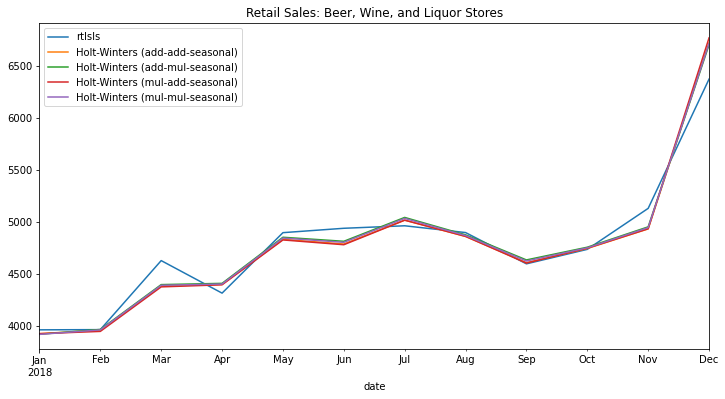

In [ ]:
# сравниваем прогнозы моделей и тестовую выборку
ax = test['rtlsls'].plot(
    legend=True, 
    figsize=(12,6), 
    title='Retail Sales: Beer, Wine, and Liquor Stores')
prediction_exps_1['Holt-Winters (add-add-seasonal)'].plot(legend=True)
prediction_exps_2['Holt-Winters (add-mul-seasonal)'].plot(legend=True)
prediction_exps_3['Holt-Winters (mul-add-seasonal)'].plot(legend=True)
prediction_exps_4['Holt-Winters (mul-mul-seasonal)'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [ ]:
# оцениваем качество моделей методом MSE, RMSE, MAE, MAPE
HW_AAS_mae_error = mean_absolute_error(test['rtlsls'], prediction_exps_1['Holt-Winters (add-add-seasonal)'])
HW_AAS_mse_error = mean_squared_error(test['rtlsls'], prediction_exps_1['Holt-Winters (add-add-seasonal)'])
HW_AAS_rmse_error = rmse(test['rtlsls'], prediction_exps_1['Holt-Winters (add-add-seasonal)'])
HW_AAS_mape_error = np.mean(np.abs(prediction_exps_1['Holt-Winters (add-add-seasonal)'] - test['rtlsls'])/test['rtlsls'])*100

print('Holt-Winters (add-add-seasonal):')
print(f'  Exponential smoothing MAE Error: {HW_AAS_mae_error:11.10}')
print(f'  Exponential smoothing MSE Error: {HW_AAS_mse_error:11.10}')
print(f'  Exponential smoothing RMSE Error: {HW_AAS_rmse_error:11.10}')
print(f'  Exponential smoothing MAPE Error: {HW_AAS_mape_error:11.10}')

HW_AMS_mae_error = mean_absolute_error(test['rtlsls'], prediction_exps_2['Holt-Winters (add-mul-seasonal)'])
HW_AMS_mse_error = mean_squared_error(test['rtlsls'], prediction_exps_2['Holt-Winters (add-mul-seasonal)'])
HW_AMS_rmse_error = rmse(test['rtlsls'], prediction_exps_2['Holt-Winters (add-mul-seasonal)'])
HW_AMS_mape_error = np.mean(np.abs(prediction_exps_2['Holt-Winters (add-mul-seasonal)'] - test['rtlsls'])/test['rtlsls'])*100

print('Holt-Winters (add-mul-seasonal):')
print(f'  Exponential smoothing MAE Error: {HW_AMS_mae_error:11.10}')
print(f'  Exponential smoothing MSE Error: {HW_AMS_mse_error:11.10}')
print(f'  Exponential smoothing RMSE Error: {HW_AMS_rmse_error:11.10}')
print(f'  Exponential smoothing MAPE Error: {HW_AMS_mape_error:11.10}')

HW_MAS_mae_error = mean_absolute_error(test['rtlsls'], prediction_exps_3['Holt-Winters (mul-add-seasonal)'])
HW_MAS_mse_error = mean_squared_error(test['rtlsls'], prediction_exps_3['Holt-Winters (mul-add-seasonal)'])
HW_MAS_rmse_error = rmse(test['rtlsls'], prediction_exps_3['Holt-Winters (mul-add-seasonal)'])
HW_MAS_mape_error = np.mean(np.abs(prediction_exps_3['Holt-Winters (mul-add-seasonal)'] - test['rtlsls'])/test['rtlsls'])*100

print('Holt-Winters (mul-add-seasonal):')
print(f'  Exponential smoothing MAE Error: {HW_MAS_mae_error:11.10}')
print(f'  Exponential smoothing MSE Error: {HW_MAS_mse_error:11.10}')
print(f'  Exponential smoothing RMSE Error: {HW_MAS_rmse_error:11.10}')
print(f'  Exponential smoothing MAPE Error: {HW_MAS_mape_error:11.10}')

HW_MMS_mae_error = mean_absolute_error(test['rtlsls'], prediction_exps_4['Holt-Winters (mul-mul-seasonal)'])
HW_MMS_mse_error = mean_squared_error(test['rtlsls'], prediction_exps_4['Holt-Winters (mul-mul-seasonal)'])
HW_MMS_rmse_error = rmse(test['rtlsls'], prediction_exps_4['Holt-Winters (mul-mul-seasonal)'])
HW_MMS_mape_error = np.mean(np.abs(prediction_exps_4['Holt-Winters (mul-mul-seasonal)'] - test['rtlsls'])/test['rtlsls'])*100

print('Holt-Winters (mul-mul-seasonal):')
print(f'  Exponential smoothing MAE Error: {HW_MMS_mae_error:11.10}')
print(f'  Exponential smoothing MSE Error: {HW_MMS_mse_error:11.10}')
print(f'  Exponential smoothing RMSE Error: {HW_MMS_rmse_error:11.10}')
print(f'  Exponential smoothing MAPE Error: {HW_MMS_mape_error:11.10}')


Holt-Winters (add-add-seasonal):
  Exponential smoothing MAE Error: 103.5647038
  Exponential smoothing MSE Error:  21686.4567
  Exponential smoothing RMSE Error: 147.2632225
  Exponential smoothing MAPE Error: 2.020402968
Holt-Winters (add-mul-seasonal):
  Exponential smoothing MAE Error: 100.3087091
  Exponential smoothing MSE Error: 19156.13364
  Exponential smoothing RMSE Error:  138.405685
  Exponential smoothing MAPE Error: 1.968399205
Holt-Winters (mul-add-seasonal):
  Exponential smoothing MAE Error: 109.3704907
  Exponential smoothing MSE Error: 25021.59543
  Exponential smoothing RMSE Error:  158.182159
  Exponential smoothing MAPE Error: 2.125331509
Holt-Winters (mul-mul-seasonal):
  Exponential smoothing MAE Error: 101.9442039
  Exponential smoothing MSE Error: 20312.10178
  Exponential smoothing RMSE Error: 142.5205311
  Exponential smoothing MAPE Error: 1.995113912


In [ ]:
# добавим данные в структуру оценки качетва моделей
mdl_qlt.append(['Holt-Winters (add-add-seasonal)', HW_AAS_mae_error, HW_AAS_mse_error, HW_AAS_rmse_error, HW_AAS_mape_error])
mdl_qlt.append(['Holt-Winters (add-mul-seasonal)', HW_AMS_mae_error, HW_AMS_mse_error, HW_AMS_rmse_error, HW_AMS_mape_error])
mdl_qlt.append(['Holt-Winters (mul-add-seasonal)', HW_MAS_mae_error, HW_MAS_mse_error, HW_MAS_rmse_error, HW_MAS_mape_error])
mdl_qlt.append(['Holt-Winters (mul-mul-seasonal)', HW_MMS_mae_error, HW_MMS_mse_error, HW_MMS_rmse_error, HW_MMS_mape_error])

In [ ]:
# проверим
mdl_qlt

[['SARIMAX(4, 1, 3)x(2, 1, [1], 12)',
  66.06013914882696,
  7896.543616365456,
  88.8624983689152,
  1.4413532991400255],
 ['PROPHET',
  98.73289646585067,
  17973.336882075644,
  134.06467425118237,
  1.9477004132111595],
 ['Holt-Winters (add-add-seasonal)',
  103.5647037602394,
  21686.456703477797,
  147.2632225081259,
  2.0204029675961253],
 ['Holt-Winters (add-mul-seasonal)',
  100.30870913504104,
  19156.133642150297,
  138.40568500661487,
  1.968399205215976],
 ['Holt-Winters (mul-add-seasonal)',
  109.3704906921638,
  25021.595428387023,
  158.18215900785722,
  2.125331508641017],
 ['Holt-Winters (mul-mul-seasonal)',
  101.94420386784468,
  20312.101778593802,
  142.5205310774339,
  1.9951139118208099]]

In [ ]:
# делаем прогноз на будущее - 1 год вперед

# обучаем модели на всем датасете
fut_model_exps_1 = ExponentialSmoothing(
    df['rtlsls'], 
    seasonal_periods=12, 
    trend = 'add',
    seasonal = 'add',
    use_boxcox=True,
    freq='MS'
).fit()

fut_model_exps_2 = ExponentialSmoothing(
    df['rtlsls'], 
    seasonal_periods=12, 
    trend = 'add',
    seasonal = 'mul',
    use_boxcox=True,
    freq='MS'
).fit()

fut_model_exps_3 = ExponentialSmoothing(
    df['rtlsls'], 
    seasonal_periods=12, 
    trend = 'mul',
    seasonal = 'add',
    use_boxcox=True,
    freq='MS'
).fit()

fut_model_exps_4 = ExponentialSmoothing(
    df['rtlsls'], 
    seasonal_periods=12, 
    trend = 'mul',
    seasonal = 'mul',
    use_boxcox=True,
    freq='MS'
).fit()

# задаем точки будущего
fut_fcast_exps_1 = fut_model_exps_1.predict(start=len(df)-1, end=len(df)+10)
fut_fcast_exps_2 = fut_model_exps_2.predict(start=len(df)-1, end=len(df)+10)
fut_fcast_exps_3 = fut_model_exps_3.predict(start=len(df)-1, end=len(df)+10)
fut_fcast_exps_4 = fut_model_exps_4.predict(start=len(df)-1, end=len(df)+10)

# преобразуем в датафреймы с индексами
fut_fcast_exps_1 = pd.DataFrame(fut_fcast_exps_1)
fut_fcast_exps_1.index = pd.date_range("2019-01-01 00:00:00", periods=12, freq="MS")
fut_fcast_exps_1.columns = ['Holt-Winters (add-add-seasonal) predict']

fut_fcast_exps_2 = pd.DataFrame(fut_fcast_exps_2)
fut_fcast_exps_2.index = pd.date_range("2019-01-01 00:00:00", periods=12, freq="MS")
fut_fcast_exps_2.columns = ['Holt-Winters (add-mul-seasonal) predict']

fut_fcast_exps_3 = pd.DataFrame(fut_fcast_exps_3)
fut_fcast_exps_3.index = pd.date_range("2019-01-01 00:00:00", periods=12, freq="MS")
fut_fcast_exps_3.columns = ['Holt-Winters (mul-add-seasonal) predict']

fut_fcast_exps_4 = pd.DataFrame(fut_fcast_exps_4)
fut_fcast_exps_4.index = pd.date_range("2019-01-01 00:00:00", periods=12, freq="MS")
fut_fcast_exps_4.columns = ['Holt-Winters (mul-mul-seasonal) predict']

In [ ]:
# проверяем
print(fut_fcast_exps_1)
print(fut_fcast_exps_2)
print(fut_fcast_exps_3)
print(fut_fcast_exps_4)

            Holt-Winters (add-add-seasonal) predict
2019-01-01                              6732.098099
2019-02-01                              4088.169884
2019-03-01                              4121.720521
2019-04-01                              4596.261317
2019-05-01                              4559.136085
2019-06-01                              5036.002477
2019-07-01                              5000.720658
2019-08-01                              5205.740627
2019-09-01                              5057.062945
2019-10-01                              4791.558906
2019-11-01                              4931.945526
2019-12-01                              5157.335906
            Holt-Winters (add-mul-seasonal) predict
2019-01-01                              6717.090216
2019-02-01                              4079.043907
2019-03-01                              4115.535977
2019-04-01                              4605.154997
2019-05-01                              4549.117049
2019-06-01  

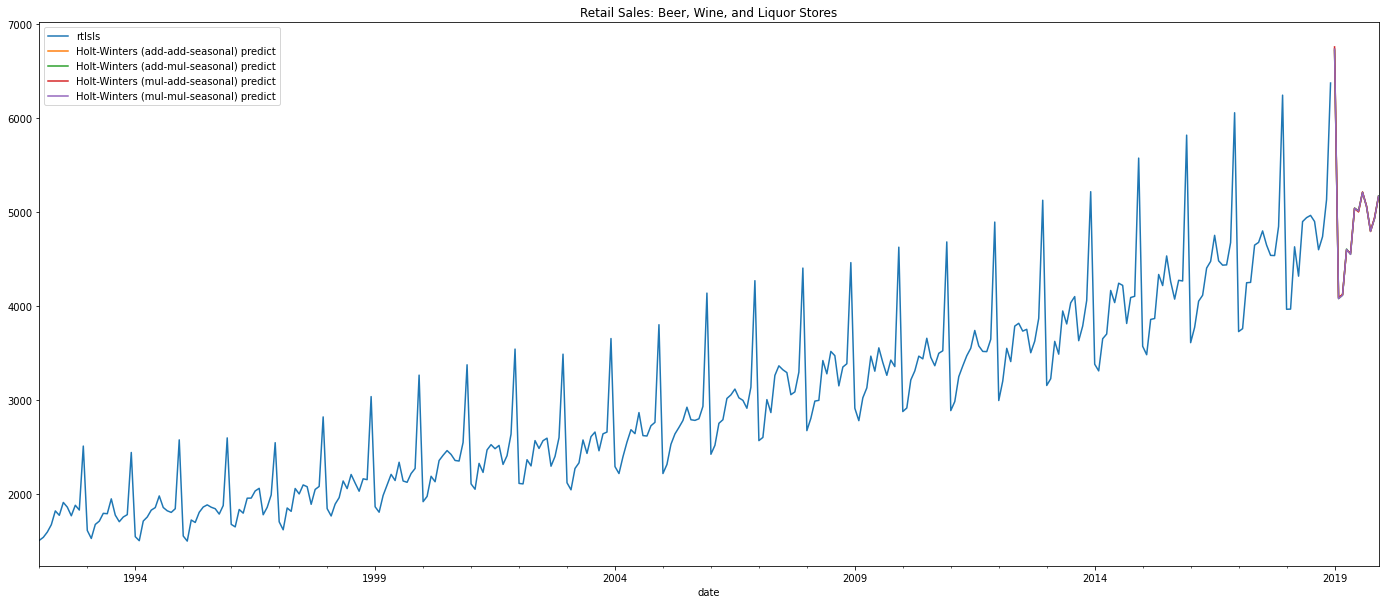

In [ ]:
# строим графики прогнозов на будущее
ax = df['rtlsls'].plot(legend=True, figsize=(24,10), title='Retail Sales: Beer, Wine, and Liquor Stores') 
fut_fcast_exps_1['Holt-Winters (add-add-seasonal) predict'].plot(legend=True)
fut_fcast_exps_2['Holt-Winters (add-mul-seasonal) predict'].plot(legend=True)
fut_fcast_exps_3['Holt-Winters (mul-add-seasonal) predict'].plot(legend=True)
fut_fcast_exps_4['Holt-Winters (mul-mul-seasonal) predict'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

##### Выводы работы метода Exponential smoothing

---
Все 4 модели экспоненциального сглаживания показали себя хорошо:
1.   Хорошие показатели RMSE:
> * Holt-Winters (add-add-seasonal) RMSE Error: 147.2632225
> * Holt-Winters (add-mul-seasonal) RMSE Error: 138.405685
> * Holt-Winters (mul-add-seasonal) RMSE Error: 158.182159
> * Holt-Winters (mul-mul-seasonal) RMSE Error: 142.5205311
2.   Не высокие проценты рассчитанной ошибки MAPE:
> * Holt-Winters (add-add-seasonal) MAPE Error: 2.020402968
> * Holt-Winters (add-mul-seasonal) MAPE Error: 1.968399205
> * Holt-Winters (mul-add-seasonal) MAPE Error: 2.125331509
> * Holt-Winters (mul-mul-seasonal) MAPE Error: 1.995113912

Согласно графику, на будущее видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается.

---

### 3.4. Сравнение качеcтва моделей

In [ ]:
# преобразуем структуру оценки качества моделей в датафрейм с удобочитаемыми заголовками
df_mdl_qlt = pd.DataFrame(
    mdl_qlt,
    columns = ['model', 'mae_error', 'mse_error', 'rmse_error', 'mape_error']
    )

In [ ]:
# посмотрим на значения критериев качества моделей и сравним их
df_mdl_qlt

,model,mae_error,mse_error,rmse_error,mape_error
0,"SARIMAX(4, 1, 3)x(2, 1, [1], 12)",66.060139,7896.543616,88.862498,1.441353
1,PROPHET,98.732896,17973.336882,134.064674,1.947700
2,Holt-Winters (add-add-seasonal),103.564704,21686.456703,147.263223,2.020403
3,Holt-Winters (add-mul-seasonal),100.308709,19156.133642,138.405685,1.968399
4,Holt-Winters (mul-add-seasonal),109.370491,25021.595428,158.182159,2.125332
5,Holt-Winters (mul-mul-seasonal),101.944204,20312.101779,142.520531,1.995114


---
**Промежуточный вывод**:

По итогам сравнения значений следующих критериев качества моделей:

*   MAE - средняя абсолютная ошибка
*   MSE - средняя квадратичная ошибка
*   RMSE - корень из средней квадратичной ошибки
*   MAPE - средняя абсолютная процентная ошибка

можно сделать вывод, что модель SARIMAX(4, 1, 3)x(2, 1, 1, 12) являетя наиболее качетсвенной, т.к. даёт наилучшие показатели по каждому из оценочных критериев.

---

## **4. Выводы.**

---
- Проведен анализ данных с использованием различных методов обработки статистической информации. 
- Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.
- Прогнозные модели позволили выявить тенденцию роста суммы розничных продаж по сравнению с предыдущим годом, а также сохранение характера амплитудных колебаний в разрезе каждого года с пиками продаж в период новогодних праздников.
- Сравнительный анализ значений критериев качетва построенных моделей показал, что наиболее качетсвенной из построенных является модель SARIMAX.
---